# Feature Engineering Notebook

This is essentially a continuation of the EDA notebook. Prior to modelling the behaviour of the energy market features need to be found and generated. 
I will do this in this notebook.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np

In [2]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau
import textwrap

In [4]:
""" from sklearn.preprocessing import MinMaxScaler 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score """

' from sklearn.preprocessing import MinMaxScaler \nfrom sklearn.linear_model import LinearRegression\nfrom sklearn.preprocessing import PolynomialFeatures\nfrom sklearn.pipeline import Pipeline\nfrom sklearn import preprocessing\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.metrics import mean_squared_error\nfrom sklearn.metrics import r2_score '

In [3]:
sns.set_style(style='darkgrid')

In [4]:
# import the dataframes
df_IGC = pd.read_pickle('../Data Cleansed/Installed_capacity.pkl')
df_RGE = pd.read_pickle('../Data Cleansed/Real_generated_energy.pkl')
df_RConE = pd.read_pickle('../Data Cleansed/Real_consumed_energy.pkl')
df_MP = pd.read_pickle('../Data Cleansed/Market_price.pkl')

In [5]:
# set Timestamp as index and resample Marketprices to 15 minutes.

In [6]:
df_IGC.set_index('Timestamp', drop=True, inplace=True)
df_RGE.set_index('Timestamp', drop=True, inplace=True)
df_RConE.set_index('Timestamp', drop=True, inplace=True)
df_MP.set_index('Timestamp', drop=True, inplace=True)


In [7]:
df_Total_IGC = pd.DataFrame()
df_Total_IGC['Renawable Capacity'] = df_IGC[['Biomass [MW]', 'Hydro [MW]', 'Wind Offshore [MW]', 'Wind Onshore [MW]', 'Photovoltaik [MW]', 'Misc Renewable [MW]']].apply(sum,axis=1)
df_Total_IGC['Conventional Capacity'] = df_IGC[['Nuclear [MW]', 'Brown Coal [MW]', 'Black Coal [MW]','Natural Gas [MW]', 'Misc conventional [MW]' ]].sum(axis=1)
df_Total_IGC['Pumped-storage [MW]'] = df_IGC[['Pumped-storage [MW]']]
df_Total_IGC['Total'] = df_Total_IGC[['Renawable Capacity', 'Conventional Capacity', 'Pumped-storage [MW]']].sum(axis=1)
df_Total_IGC.rename(columns={'Pumped-storage [MW]':'Pumped Storage'}, inplace=True)

In [8]:
df_Total_RGE = pd.DataFrame()
df_Total_RGE['Total Renewable Energy'] = df_RGE[['Biomass [MWh]', 'Hydro [MWh]', 'Wind Offshore [MWh]', 'Wind Onshore [MWh]', 'Photovoltaik [MWh]', 'Misc Renewable [MWh]']].sum(axis=1)
df_Total_RGE['Total Conventional Energy'] = df_RGE[['Nuclear [MWh]', 'Brown Coal [MWh]', 'Black Coal [MWh]','Natural Gas [MWh]', 'Misc conventional [MWh]' ]].sum(axis=1)
df_Total_RGE['Pumped-storage [MWh]'] = df_RGE[['Pumped-storage [MWh]']]
df_Total_RGE['Total'] = df_Total_RGE[['Total Renewable Energy', 'Total Conventional Energy', 'Pumped-storage [MWh]']].sum(axis=1)

df_Total_RGE['year'] = df_Total_RGE.index
df_Total_RGE['month'] = df_Total_RGE['year'].dt.month
df_Total_RGE['day'] = df_Total_RGE['year'].dt.day
df_Total_RGE['day_of_year'] = df_Total_RGE['year'].dt.dayofyear
df_Total_RGE['year'] = df_Total_RGE['year'].dt.year

In [9]:
df_Total_RConE = df_RConE
df_Total_RConE.rename(columns={'Total (Grid Load) [MWh]':'Total', 'Residuallast [MWh]':'Residual Load', 'Pumpspeicher [MWh]':'Pumped Storage'}, inplace=True)
df_Total_RConE['Renewables'] = df_Total_RConE['Total'] - df_Total_RConE['Residual Load'] - df_Total_RConE['Pumped Storage']

df_Total_RConE['year'] = df_Total_RConE.index
df_Total_RConE['month'] = df_Total_RConE['year'].dt.month
df_Total_RConE['day'] = df_Total_RConE['year'].dt.day
df_Total_RConE['day_of_year'] = df_Total_RConE['year'].dt.dayofyear
df_Total_RConE['year'] = df_Total_RConE['year'].dt.year

In [10]:
# no need to consider the market prices outside of Germany
MP_DE = df_MP[['Germany/Luxemburg [€/MWh]']]
MP_DE.rename(columns={'Germany/Luxemburg [€/MWh]': 'DE'}, inplace=True)
#resample MP_DE
#MP_DE = MP_DE.resample('15 Min').ffill() #just fills the NAN with the last known value
MP_DE =MP_DE.resample('15 Min').interpolate(method='linear') # alternative use would be method='time'

C:\Users\sager\AppData\Local\Temp\ipykernel_394360\3587077433.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MP_DE.rename(columns={'Germany/Luxemburg [€/MWh]': 'DE'}, inplace=True)


In [11]:
# del unncessary Dataframes to conserve memory
del df_MP
del df_RConE

- df_IGC: Capacities by type
- df_Total_IGC: Total capacities
- df_RGE: Generated Energy by type
- df_Total_RGE: Total Generated Energies
- df_Total_RConE: Total Consumed Energies
- MP_DE: Market prices in Germany 


### Correlations between market price and Consumed Energy

In [12]:
MP_RCON = MP_DE.join(df_Total_RConE, how='inner', validate='one_to_one') # outer join on index aka Timestamp

In [13]:
MP_RCON.head()

,DE,Total,Residual Load,Pumped Storage,Renewables,year,month,day,day_of_year
Timestamp,,,,,,,,,
2021-01-01 01:00:00,50.87,11044.25,10017.25,155.00,872.00,2021,1,1,1
2021-01-01 01:15:00,50.20,10879.25,9850.25,90.00,939.00,2021,1,1,1
2021-01-01 01:30:00,49.53,10749.50,9744.75,61.25,943.50,2021,1,1,1
2021-01-01 01:45:00,48.86,10623.50,9657.00,105.75,860.75,2021,1,1,1
2021-01-01 02:00:00,48.19,10580.00,9644.25,122.25,813.50,2021,1,1,1


In [14]:
MP_RCON.dtypes

DE                float64
Total             float64
Residual Load     float64
Pumped Storage    float64
Renewables        float64
year                int32
month               int32
day                 int32
day_of_year         int32
dtype: object

In [15]:
MP_RCON.describe()

,DE,Total,Residual Load,Pumped Storage,Renewables,year,month,day,day_of_year
count,105105.000000,105105.000000,105105.000000,105105.000000,105105.000000,105105.000000,105105.000000,105105.000000,105105.000000
mean,142.503748,13745.178284,8625.340850,378.075767,4741.761667,2022.000057,6.526588,15.719680,183.016269
std,116.632335,2413.151107,3327.339221,450.899550,3011.172918,0.816512,3.447781,8.795735,105.364463
min,-500.000000,6984.750000,-1545.000000,0.000000,-1064.000000,2021.000000,1.000000,1.000000,1.000000
25%,70.275000,11795.500000,6360.250000,26.500000,2216.250000,2021.000000,4.000000,8.000000,92.000000
50%,105.950000,13734.250000,8743.250000,172.000000,4415.750000,2022.000000,7.000000,16.000000,183.000000
75%,183.100000,15632.500000,10941.500000,614.750000,6931.500000,2023.000000,10.000000,23.000000,274.000000
max,871.000000,20341.500000,17855.750000,2188.250000,14517.500000,2024.000000,12.000000,31.000000,365.000000


In [16]:
MP_RCON.isna().any()

DE                False
Total             False
Residual Load     False
Pumped Storage    False
Renewables        False
year              False
month             False
day               False
day_of_year       False
dtype: bool

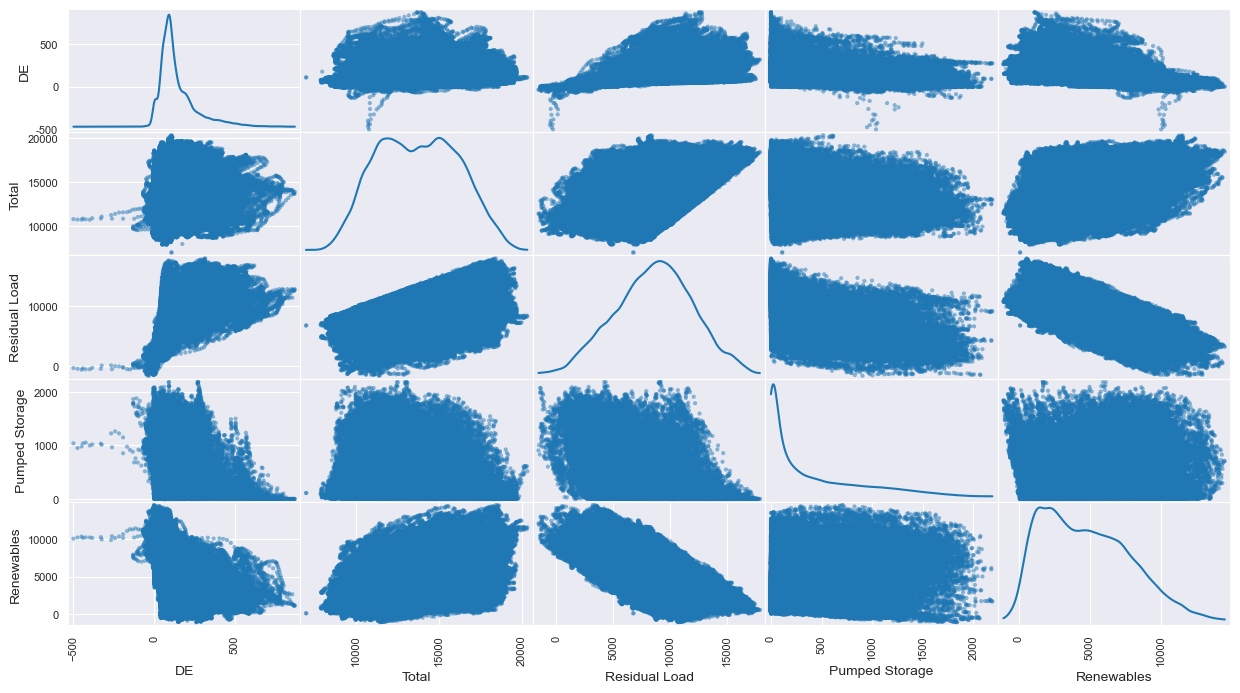

In [17]:
pd.plotting.scatter_matrix(MP_RCON[['DE', 'Total', 'Residual Load', 'Pumped Storage', 'Renewables']], figsize=(15,8), diagonal='kde')
plt.show()

In [18]:
corr=MP_RCON[['DE', 'Total', 'Residual Load', 'Pumped Storage', 'Renewables']].corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

,DE,Total,Residual Load,Pumped Storage,Renewables
DE,1.000,0.145,0.451,-0.272,-0.341
Total,0.145,1.000,0.437,-0.308,0.365
Residual Load,0.451,0.437,1.000,-0.561,-0.671
Pumped Storage,-0.272,-0.308,-0.561,1.000,0.223
Renewables,-0.341,0.365,-0.671,0.223,1.000


**What happens, if I don't take resampled date for correlation? Correlation values are slightly different, but not much.**

### Correlation between Generated Energy and Market price
there might be some correlation between Market Prices and residual load

In [19]:
MP_RGE = MP_DE.join(df_RGE, how='inner', validate='one_to_one') # outer join on index aka Timestamp

In [20]:
print('dtypes:')
print(MP_RGE.dtypes)
print('\n')
print(MP_RGE.describe())
print('\n')
print(MP_RGE.isna().any())


dtypes:
DE                         float64
Biomass [MWh]              float64
Hydro [MWh]                float64
Wind Offshore [MWh]        float64
Wind Onshore [MWh]         float64
Photovoltaik [MWh]         float64
Misc Renewable [MWh]       float64
Nuclear [MWh]              float64
Brown Coal [MWh]           float64
Black Coal [MWh]           float64
Natural Gas [MWh]          float64
Pumped-storage [MWh]       float64
Misc conventional [MWh]    float64
dtype: object


                  DE  Biomass [MWh]    Hydro [MWh]  Wind Offshore [MWh]  \
count  105105.000000  105105.000000  105105.000000        105105.000000   
mean      142.503748    1110.689672     392.499867           687.570403   
std       116.632335      68.351711      95.278446           479.680755   
min      -500.000000     892.000000     209.500000             0.000000   
25%        70.275000    1060.000000     315.250000           248.500000   
50%       105.950000    1115.000000     373.500000           626.250000

In [21]:
MP_RGE = MP_RGE.join(df_Total_RGE[['Total', 'Total Renewable Energy', 'Total Conventional Energy']], how='inner', validate='one_to_one') # outer join on index aka Timestamp

In [22]:
print('dtypes:')
print(MP_RGE.dtypes)
print('\n')
print(MP_RGE.describe())
print('\n')
print(MP_RGE.isna().any())

dtypes:
DE                           float64
Biomass [MWh]                float64
Hydro [MWh]                  float64
Wind Offshore [MWh]          float64
Wind Onshore [MWh]           float64
Photovoltaik [MWh]           float64
Misc Renewable [MWh]         float64
Nuclear [MWh]                float64
Brown Coal [MWh]             float64
Black Coal [MWh]             float64
Natural Gas [MWh]            float64
Pumped-storage [MWh]         float64
Misc conventional [MWh]      float64
Total                        float64
Total Renewable Energy       float64
Total Conventional Energy    float64
dtype: object


                  DE  Biomass [MWh]    Hydro [MWh]  Wind Offshore [MWh]  \
count  105105.000000  105105.000000  105105.000000        105105.000000   
mean      142.503748    1110.689672     392.499867           687.570403   
std       116.632335      68.351711      95.278446           479.680755   
min      -500.000000     892.000000     209.500000             0.000000   
25%      

In [23]:
MP_RGE.corr(method='pearson').style.background_gradient(cmap='coolwarm').format(precision=3)

,DE,Biomass [MWh],Hydro [MWh],Wind Offshore [MWh],Wind Onshore [MWh],Photovoltaik [MWh],Misc Renewable [MWh],Nuclear [MWh],Brown Coal [MWh],Black Coal [MWh],Natural Gas [MWh],Pumped-storage [MWh],Misc conventional [MWh],Total,Total Renewable Energy,Total Conventional Energy
DE,1.000,0.215,-0.204,-0.208,-0.355,-0.084,-0.085,0.008,0.499,0.578,0.130,0.271,-0.074,-0.011,-0.370,0.428
Biomass [MWh],0.215,1.000,-0.433,0.130,0.075,-0.273,0.604,0.404,0.387,0.464,0.336,0.400,0.301,0.374,-0.113,0.533
Hydro [MWh],-0.204,-0.433,1.000,-0.287,-0.264,0.188,-0.426,-0.092,-0.230,-0.369,-0.088,0.061,-0.187,-0.316,-0.089,-0.274
Wind Offshore [MWh],-0.208,0.130,-0.287,1.000,0.611,-0.217,0.163,0.026,-0.197,-0.130,-0.171,-0.014,0.063,0.366,0.459,-0.159
Wind Onshore [MWh],-0.355,0.075,-0.264,0.611,1.000,-0.217,0.046,-0.120,-0.470,-0.274,-0.265,-0.049,-0.007,0.437,0.699,-0.381
Photovoltaik [MWh],-0.084,-0.273,0.188,-0.217,-0.217,1.000,-0.276,-0.088,-0.206,-0.197,-0.191,-0.245,-0.135,0.360,0.536,-0.230
Misc Renewable [MWh],-0.085,0.604,-0.426,0.163,0.046,-0.276,1.000,0.552,0.404,0.433,0.532,0.043,0.630,0.382,-0.140,0.636
Nuclear [MWh],0.008,0.404,-0.092,0.026,-0.120,-0.088,0.552,1.000,0.327,0.240,0.102,-0.059,0.409,0.284,-0.146,0.542
Brown Coal [MWh],0.499,0.387,-0.230,-0.197,-0.470,-0.206,0.404,0.327,1.000,0.722,0.488,0.155,0.218,0.151,-0.542,0.866
Black Coal [MWh],0.578,0.464,-0.369,-0.130,-0.274,-0.197,0.433,0.240,0.722,1.000,0.537,0.197,0.274,0.331,-0.376,0.858


**Again not much difference betweeen Pearson and Spearman**

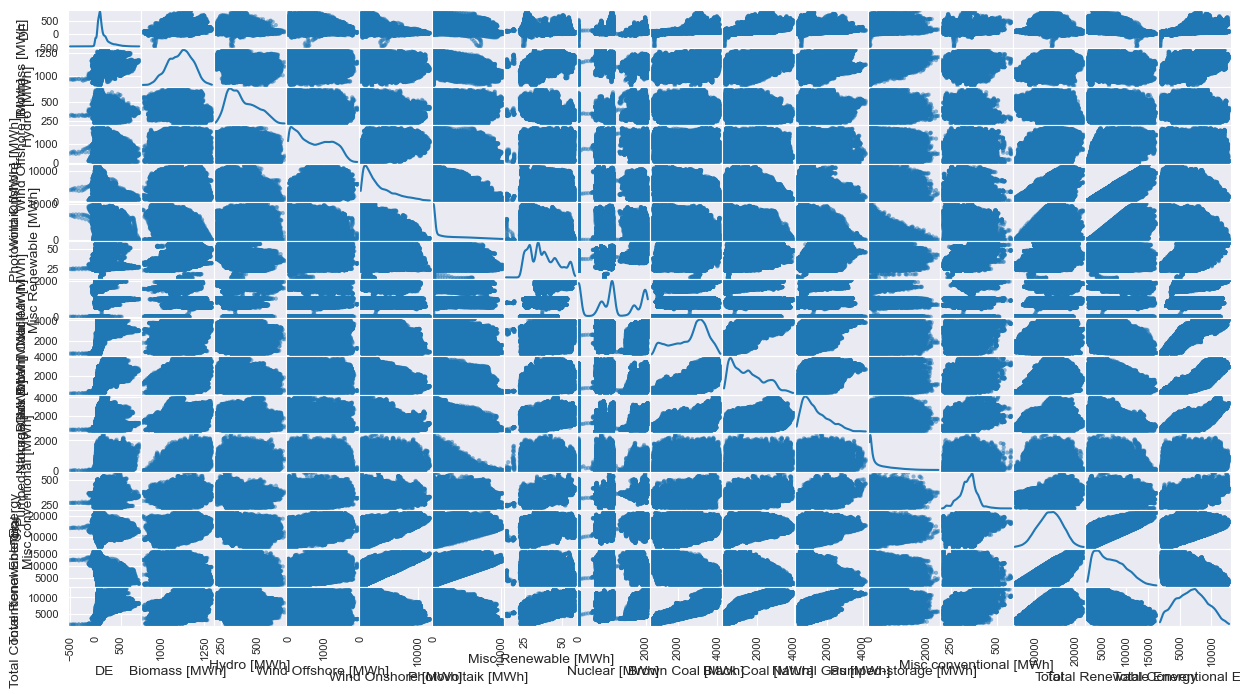

In [24]:
pd.plotting.scatter_matrix(MP_RGE, figsize=(15,8), diagonal='kde')
plt.show()

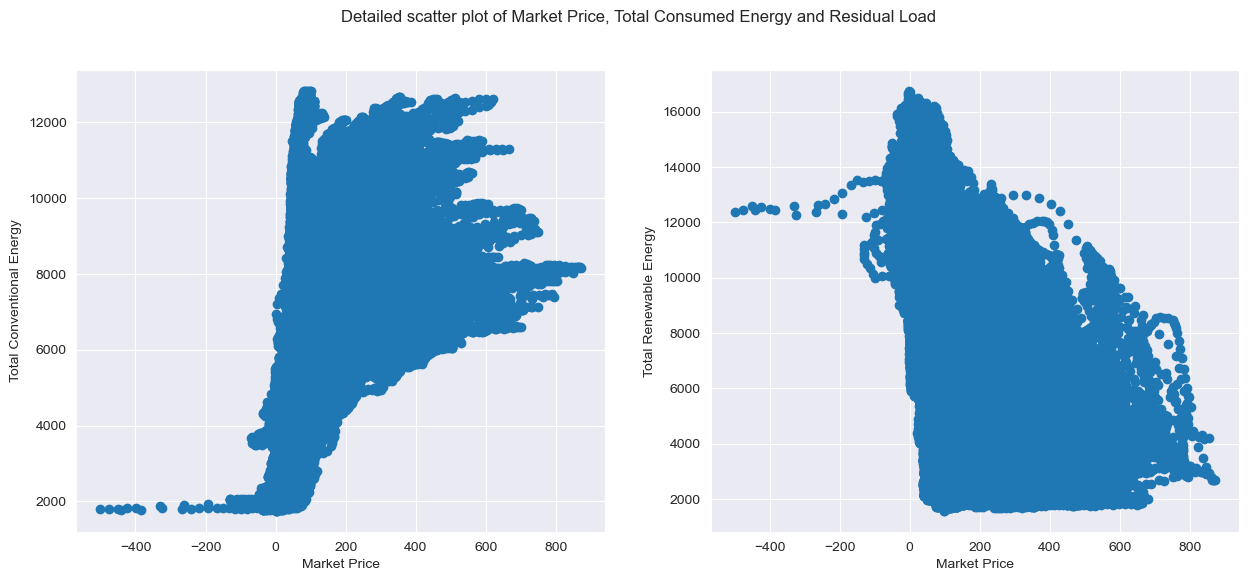

In [25]:
fig, axs = plt.subplots(1,2, figsize=(15,6))
fig.suptitle('Detailed scatter plot of Market Price, Total Consumed Energy and Residual Load')
axs[0].scatter(x=MP_RCON['DE'], y=MP_RGE['Total Conventional Energy'])
axs[0].set_xlabel('Market Price')
axs[0].set_ylabel('Total Conventional Energy')
axs[1].set_xlabel('Market Price')
axs[1].set_ylabel('Total Renewable Energy')
axs[1].scatter(x=MP_RCON['DE'], y=MP_RGE['Total Renewable Energy'])
plt.show()

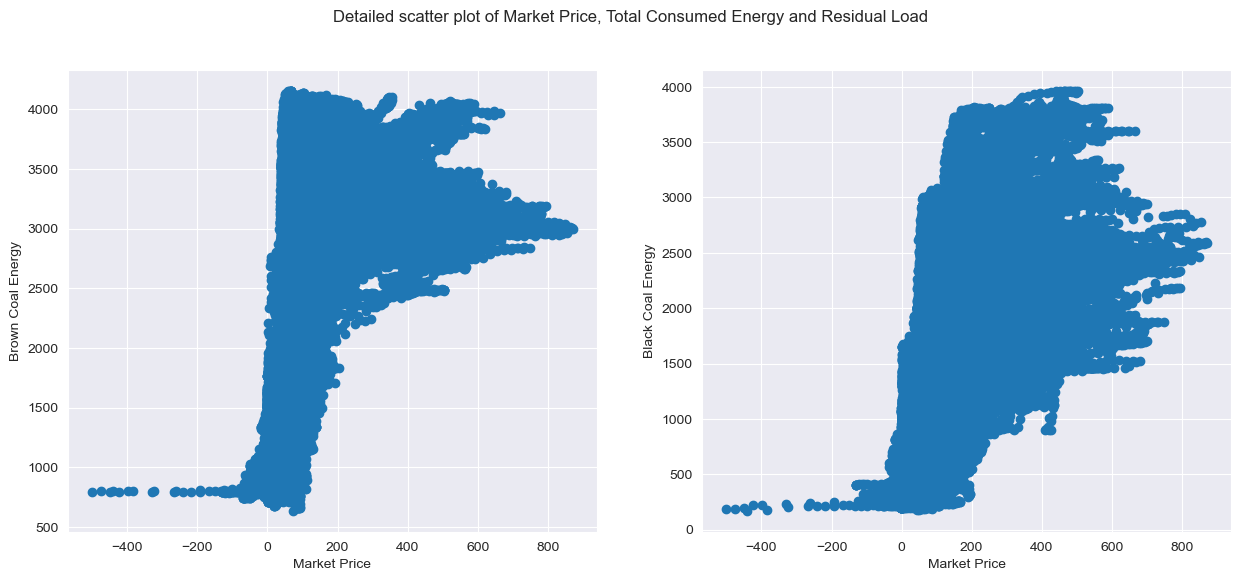

In [30]:
fig, axs = plt.subplots(1,2, figsize=(15,6))
fig.suptitle('Detailed scatter plot of Market Price, Total Consumed Energy and Residual Load')
axs[0].scatter(x=MP_RCON['DE'], y=MP_RGE['Brown Coal [MWh]'])
axs[0].set_xlabel('Market Price')
axs[0].set_ylabel('Brown Coal Energy')
axs[1].set_xlabel('Market Price')
axs[1].set_ylabel('Black Coal Energy')
axs[1].scatter(x=MP_RCON['DE'], y=MP_RGE['Black Coal [MWh]'])
plt.show()

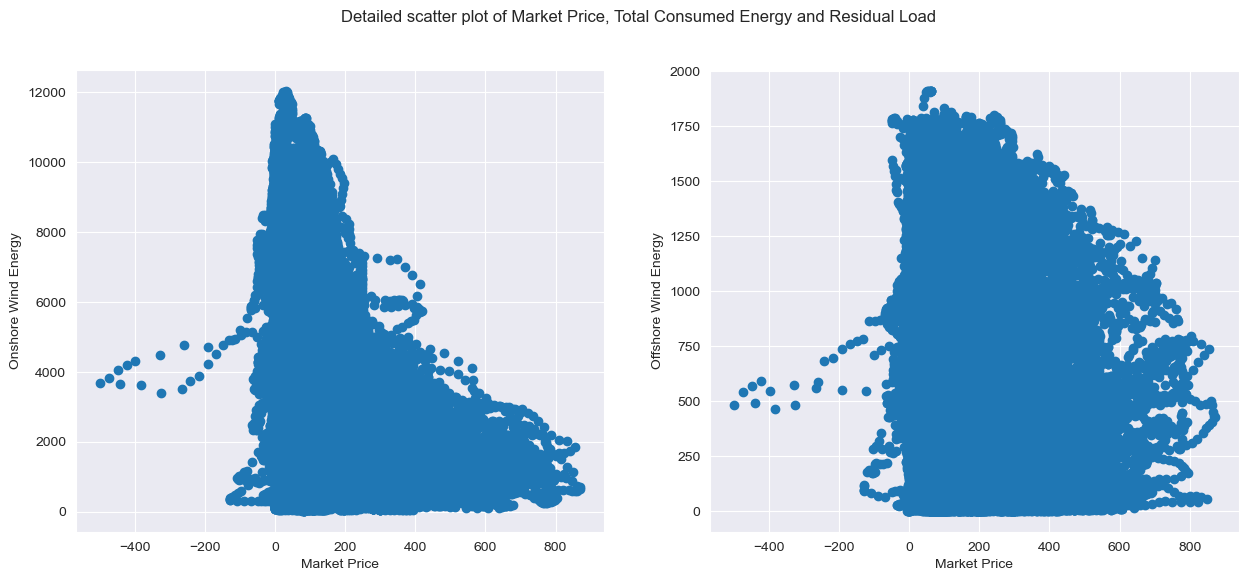

In [26]:
fig, axs = plt.subplots(1,2, figsize=(15,6))
fig.suptitle('Detailed scatter plot of Market Price, Total Consumed Energy and Residual Load')
axs[0].scatter(x=MP_RCON['DE'], y=MP_RGE['Wind Onshore [MWh]'])
axs[0].set_xlabel('Market Price')
axs[0].set_ylabel('Onshore Wind Energy')
axs[1].set_xlabel('Market Price')
axs[1].set_ylabel('Offshore Wind Energy')
axs[1].scatter(x=MP_RCON['DE'], y=MP_RGE['Wind Offshore [MWh]'])
plt.show()

**Let's check for any autocorrelation of the data**

DE autocorrelation hourly (lag 4): 
0.9841047579404197
DE autocorrelation daily (lag 96): 
0.8749182538500151
DE autocorrelation weekly (672): 
0.7740093024034868
DE autocorrelation yearly (35040): 
-0.1814567991045894


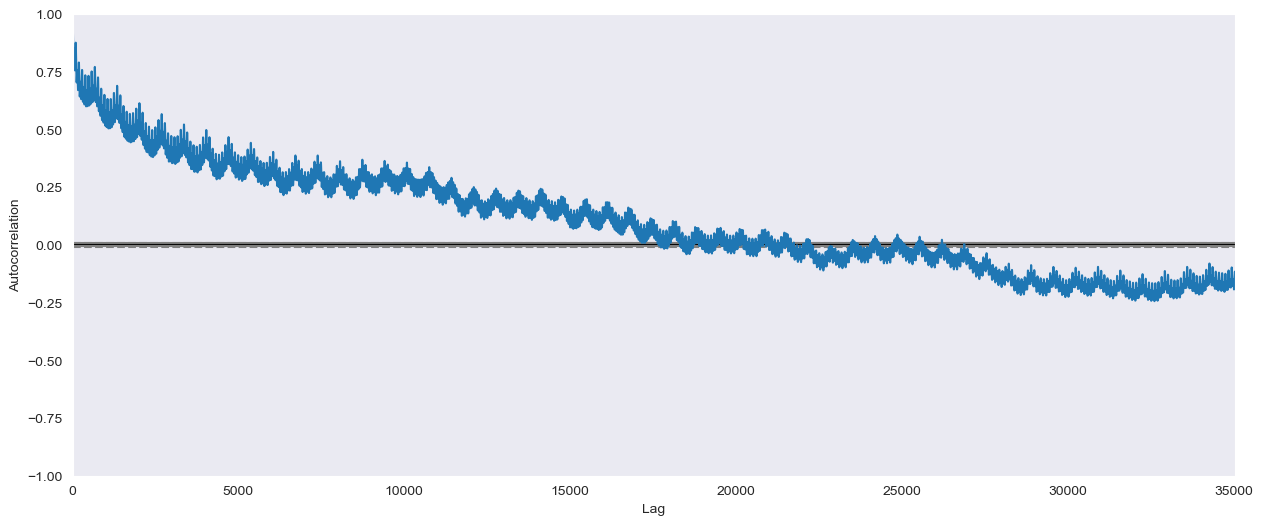

In [27]:
plt.figure(figsize=(15,6))
pd.plotting.autocorrelation_plot(MP_RCON['DE'])
plt.xlim(0,365*24*4)
print('DE autocorrelation hourly (lag 4): ')
print(MP_RCON['DE'].autocorr(lag=4)) #lag 4 is necessary as I don't want to autocorrelate the market price values with its own interpolated values)
print('DE autocorrelation daily (lag 96): ')
print(MP_RCON['DE'].autocorr(lag=24*4))
print('DE autocorrelation weekly (672): ')
print(MP_RCON['DE'].autocorr(lag=7*24*4))
print('DE autocorrelation yearly (35040): ')
print(MP_RCON['DE'].autocorr(lag=365*24*4))


Residual Load autocorrelation 15 Min:
0.9978771386504051
Residual Load autocorrelation daily (lag 96):
0.6727948844633972
Residual Load autocorrelation weekly (672):
0.5019592939184163
Residual Load autocorrelation weekly (35040): 
0.416043180846064


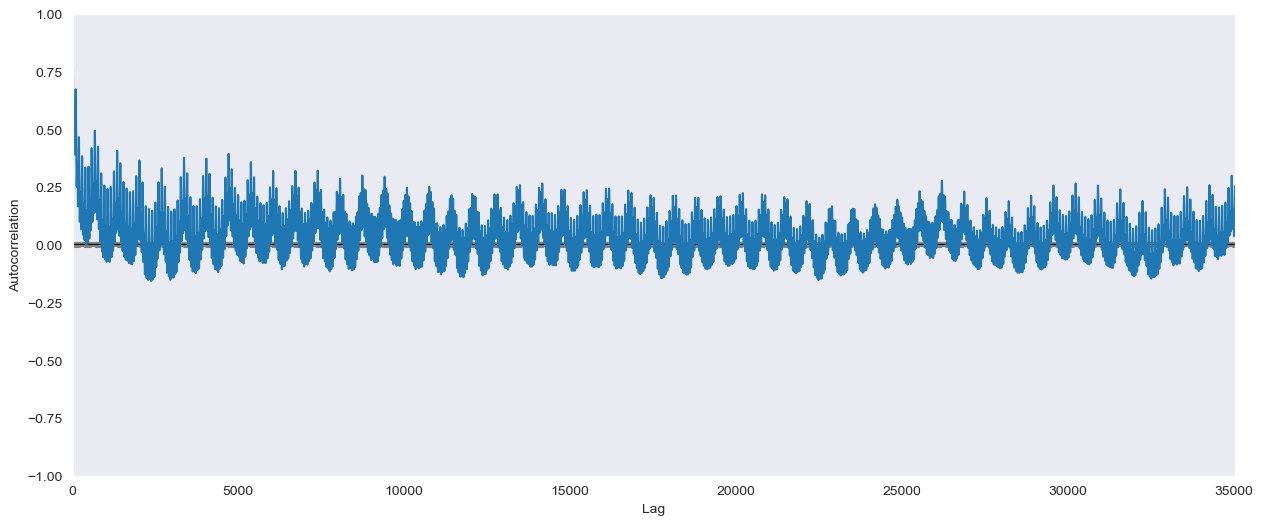

In [28]:
plt.figure(figsize=(15,6))
pd.plotting.autocorrelation_plot(MP_RCON['Residual Load'])
plt.xlim(0,365*24*4)
print('Residual Load autocorrelation 15 Min:')
print(MP_RCON['Residual Load'].autocorr())
print('Residual Load autocorrelation daily (lag 96):')
print(MP_RCON['Residual Load'].autocorr(24*4))
print('Residual Load autocorrelation weekly (672):')
print(MP_RCON['Residual Load'].autocorr(7*24*4))
print('Residual Load autocorrelation weekly (35040): ')
print(MP_RCON['Residual Load'].autocorr(lag=365*24*4))

Renewables Load autocorrelation 15 Min:
0.9980430946792272
Residual Load autocorrelation daily (lag 96):
0.695433688994226
Residual Load autocorrelation weekly (672):
0.4237759924471865
Residual Load autocorrelation yearly (35040):
0.4035189068224228


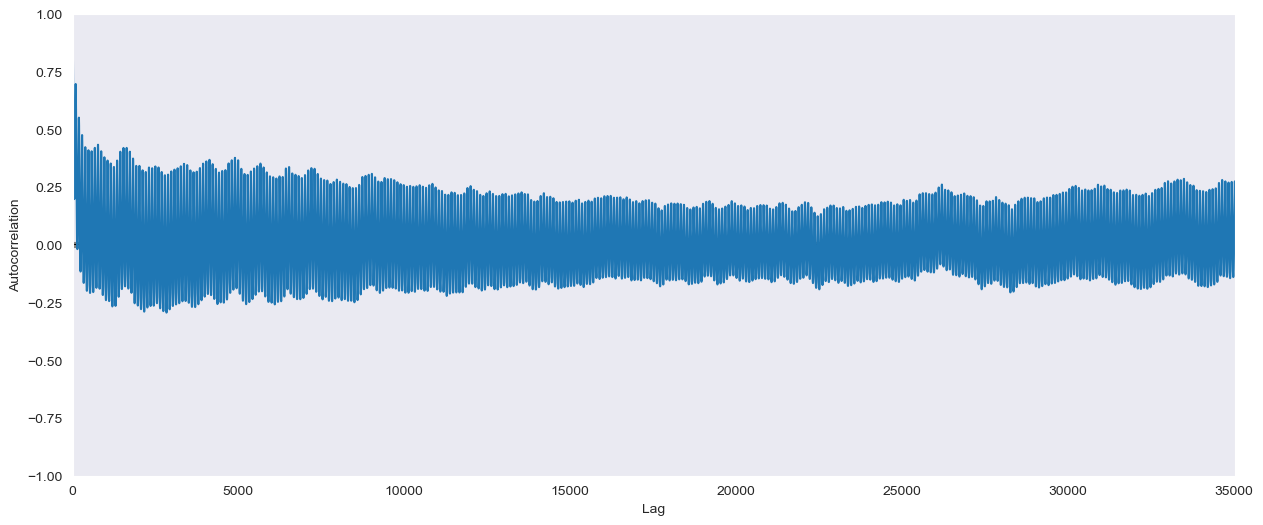

In [29]:
plt.figure(figsize=(15,6))
pd.plotting.autocorrelation_plot(MP_RCON['Renewables'])
plt.xlim(0,365*24*4)
print('Renewables Load autocorrelation 15 Min:')
print(MP_RCON['Renewables'].autocorr())
print('Residual Load autocorrelation daily (lag 96):')
print(MP_RCON['Renewables'].autocorr(24*4))
print('Residual Load autocorrelation weekly (672):')
print(MP_RCON['Renewables'].autocorr(7*24*4))
print('Residual Load autocorrelation yearly (35040):')
print(MP_RCON['Renewables'].autocorr(365*24*4))

**Not much of an autocorrelation in Renewables and Residual Load, but a week autocorrelation in the market price on weekly and monthly basis.**

**Let's see if things become clearer with a longer period of observation**

In [30]:
Long_MP_RCON = pd.read_pickle('../Data Cleansed/Since_2019_Market_price_Real_consumed_energy.pkl')

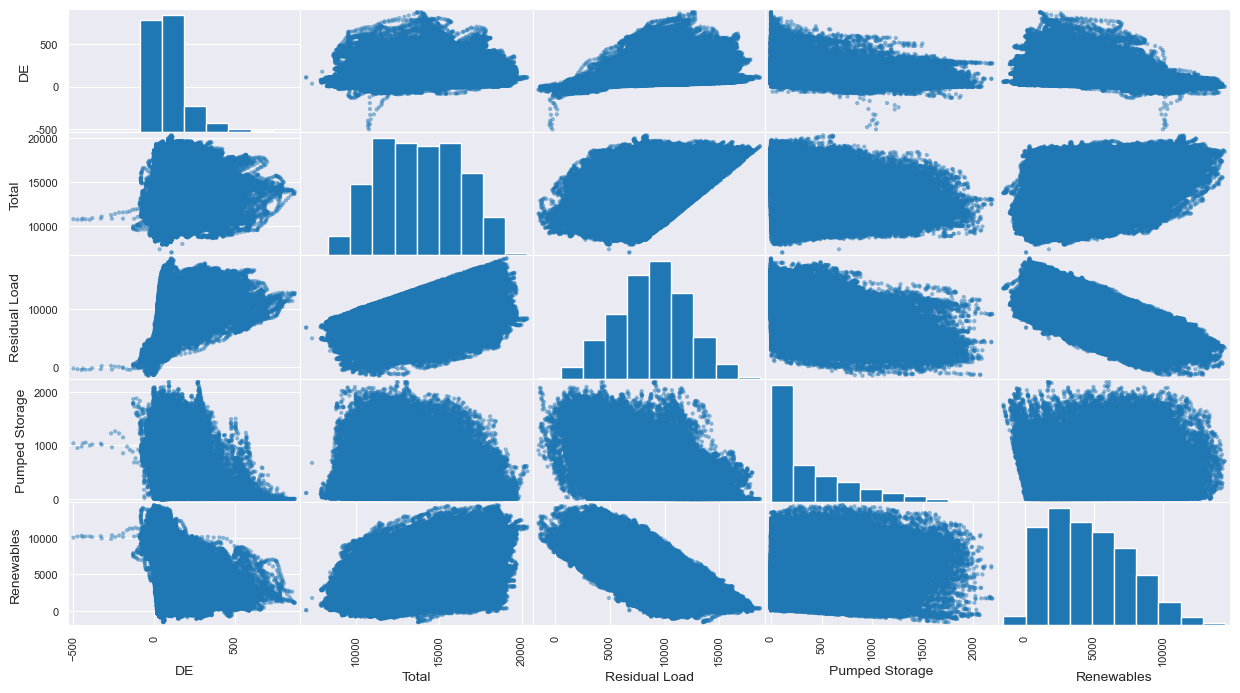

In [31]:
pd.plotting.scatter_matrix(Long_MP_RCON[['DE', 'Total', 'Residual Load', 'Pumped Storage', 'Renewables']], figsize=(15,8))
plt.show()

In [32]:
corr=Long_MP_RCON[['DE', 'Total', 'Residual Load', 'Pumped Storage', 'Renewables']].corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

,DE,Total,Residual Load,Pumped Storage,Renewables
DE,1.000,0.099,0.319,-0.212,-0.239
Total,0.099,1.000,0.458,-0.328,0.371
Residual Load,0.319,0.458,1.000,-0.506,-0.648
Pumped Storage,-0.212,-0.328,-0.506,1.000,0.144
Renewables,-0.239,0.371,-0.648,0.144,1.000


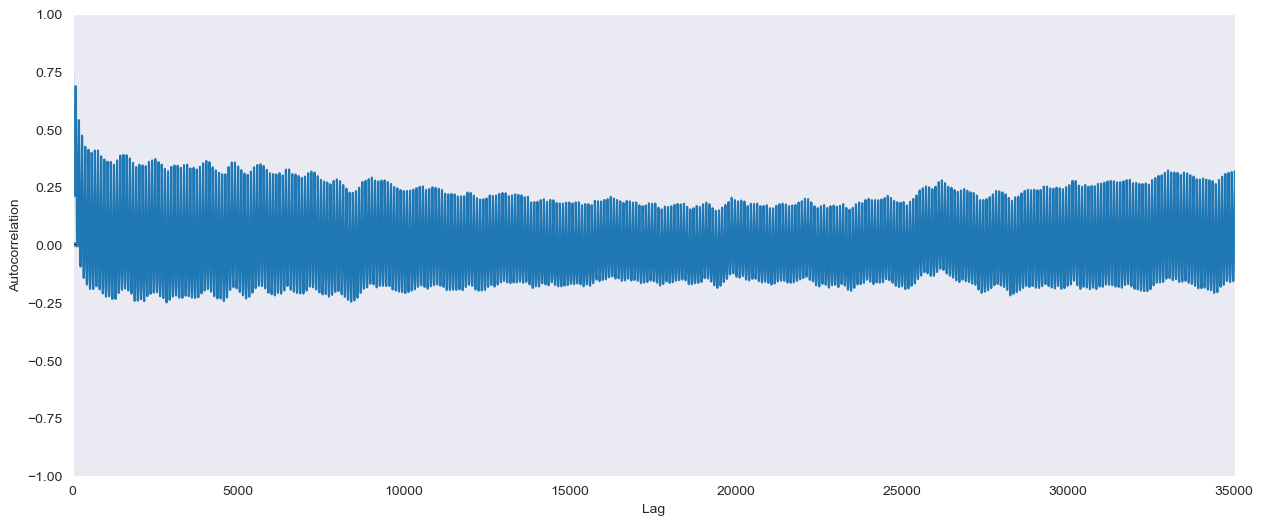

Renewables Load autocorrelation 15 Min:
0.9980128156210657
Residual Load autocorrelation daily (lag 96):
0.6854502642990842
Residual Load autocorrelation weekly (672):
0.4107960266471114
Residual Load autocorrelation yearly (35040):
0.38232175049784684


In [33]:
plt.figure(figsize=(15,6))
pd.plotting.autocorrelation_plot(Long_MP_RCON['Renewables'])
plt.xlim(0,365*24*4)
plt.show()
print('Renewables Load autocorrelation 15 Min:')
print(Long_MP_RCON['Renewables'].autocorr())
print('Residual Load autocorrelation daily (lag 96):')
print(Long_MP_RCON['Renewables'].autocorr(24*4))
print('Residual Load autocorrelation weekly (672):')
print(Long_MP_RCON['Renewables'].autocorr(7*24*4))
print('Residual Load autocorrelation yearly (35040):')
print(Long_MP_RCON['Renewables'].autocorr(365*24*4))

**Wait! Where are the p-values in the correlation matrices?**
Considering the number of entries in each column, the p-values rapidly detoriate to 0. But that doesn't mean that htere is a high likely-ness of correlation. This has rather something to do iwth the number of samples in the dataframe. Therefore I have omitted that here. If you don't belive me, look at the following example.